In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR


import torch.nn.functional as F
import torchvision.transforms as T

from tqdm import tqdm

from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv,GraphConv, ChebConv
from torch_geometric.data import Data

import pyproj

PROJ = pyproj.Proj(proj='stere',  a=6378273, b=6378273, lon_0=-45, lat_0=90, lat_ts=90)

##Adding src path to get our code
import sys
sys.path.append('../src')
from ice_graph.ice_graph import Nextsim_data, Ice_graph
from utils.graph_utils import standardize_graph
from utils.metrics import velocity_from_coords, velocity_norm, velocity_angle
from models.training_utils import process_dataloader

## Sea Ice ML - Training and data handling example

Here it is presented how to create custom graphs centered on neXTSIM elements, convert them into pytorch geometric data classes and train a simple GNN to predict trajectories.

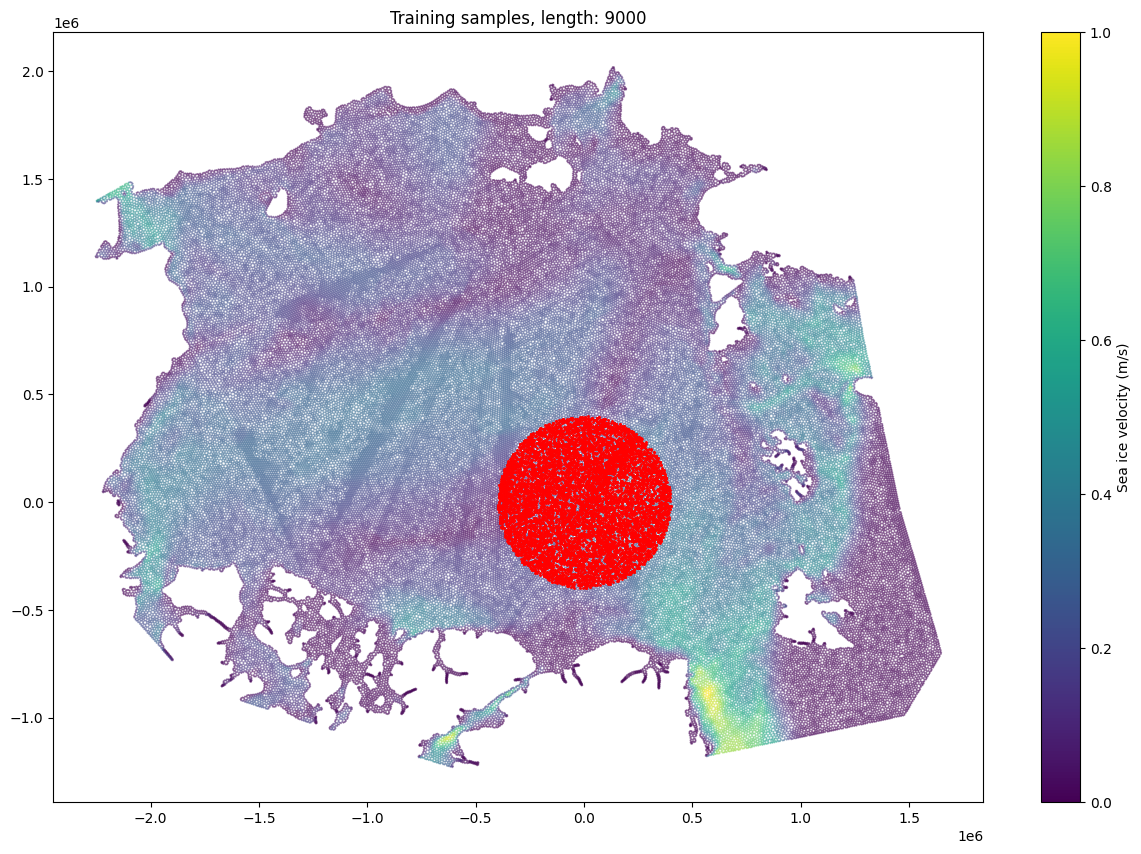

In [2]:
#Load the files (Note, you need to clone the repo first -- upper cells)
file_graphs = [dict(np.load(f'../example_data/{file}')) for file in sorted(os.listdir('../example_data')) if file[-3:]=='npz']
nextsim = Ice_graph(
    file_graphs,
    vertex_element_features =
        ['M_wind_x',
        'M_wind_y',
        'M_ocean_x',
        'M_ocean_y',
        'M_VT_x',
        'M_VT_y',
        'x',
        'y']
)

#Here we can generate samples from an hour snapshot to create a training dataset
#We can either select randomly or within a radious from a given element.
#seed for reproducibility
np.random.seed(42)


n_generations = 9000

radius = 400000 #meters
n_neighbours = 4
iterations = 1
time_index = 6 #index of element graph to fetch samples from
val_time_index = time_index+iterations

samples_train = nextsim.get_samples_area((0,0),radius,time_index=time_index,n_samples=n_generations,elements=True)
samples_val = nextsim.get_samples_area((0,0),radius,time_index=val_time_index,n_samples=int(n_generations/4),elements=True) #just 1/4 of items for validation

selected_graph = nextsim.get_item(time_index,elements=True) 

#plot area defined by radius
plt.figure(figsize=(15,10))
vel_norm = np.sqrt(selected_graph['M_VT_x']**2 + selected_graph['M_VT_y']**2)
plt.scatter(selected_graph['x'],selected_graph['y'],c=vel_norm, s= 3 ,marker='.',linewidths=.7,alpha=.4)
plt.title("Training samples, length: "+str(len(samples_train)))
plt.scatter(selected_graph['x'][samples_train],selected_graph['y'][samples_train], color='red',s= 7 ,marker='.',linewidths=.7)
plt.colorbar(label='Sea ice velocity (m/s)')


element_g = nextsim.get_element_graph(samples_train[400],time_index=time_index,n_neighbours=n_neighbours,target_iter=iterations,predict_element=True)
vertex_g = nextsim.get_vertex_graph(samples_train[400],time_index=time_index,n_neighbours=n_neighbours,target_iter=iterations,predict_element=False)


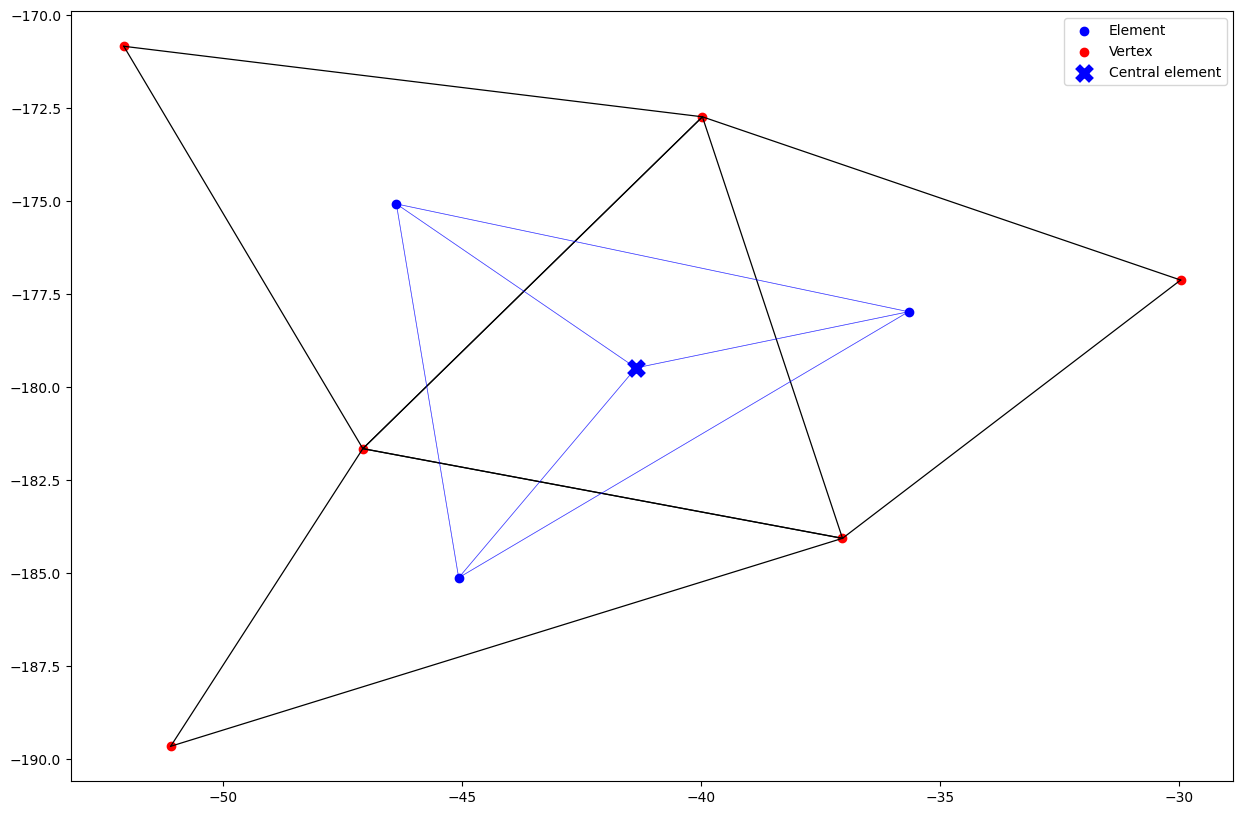

In [3]:
plt.figure(figsize=(15,10))
central_pos = selected_graph['x'][samples_train[400]]/1000,selected_graph['y'][samples_train[400]]/1000


for edge in vertex_g.edge_index.t():
    positions = np.array([vertex_g.pos.t()[edge[0]],vertex_g.pos.t()[edge[1]]])
    positions = positions.transpose()
    plt.plot(positions[0],positions[1],color='black',linewidth=.9)

for edge in element_g.edge_index.t():
    positions = np.array([element_g.pos.t()[edge[0]],element_g.pos.t()[edge[1]]])
    positions = positions.transpose()
    plt.plot(positions[0],positions[1],color='blue',linewidth=.5,alpha=.5)

plt.scatter(element_g.pos[0],element_g.pos[1],color='blue',label='Element')
plt.scatter(vertex_g.pos[0],vertex_g.pos[1],color='red',label='Vertex')

plt.scatter(central_pos[0],central_pos[1],marker='x', s=100, linewidth=5, c='blue', label='Central element')

plt.legend()

In [4]:

fet = ['Damage', 'Concentration', 'Thickness', 'Sigma_0', 'Sigma_1', 'M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'x', 'y']


train_graph_list = []
fet = ['Damage', 'Concentration', 'Thickness', 'Sigma_0', 'Sigma_1', 'M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'x', 'y']
for sample in tqdm(samples_train,"Generating training graphs"):
    graph = nextsim.get_element_graph(sample,time_index=time_index,n_neighbours=n_neighbours,target_iter=iterations,features=fet,predict_element=True)
    if graph is not None:
        train_graph_list.append(graph)


val_graph_list = []
for sample in tqdm(samples_val,"Generating validation graphs"):
    graph = nextsim.get_element_graph(sample,time_index=val_time_index,n_neighbours=n_neighbours,target_iter=iterations,features=fet,predict_element=True)
    if graph is not None:
        val_graph_list.append(graph)

Generating validation graphs: 100%|██████████| 2250/2250 [00:11<00:00, 203.71it/s]


Text(0.5, 1.0, 'Training targets not normalized')

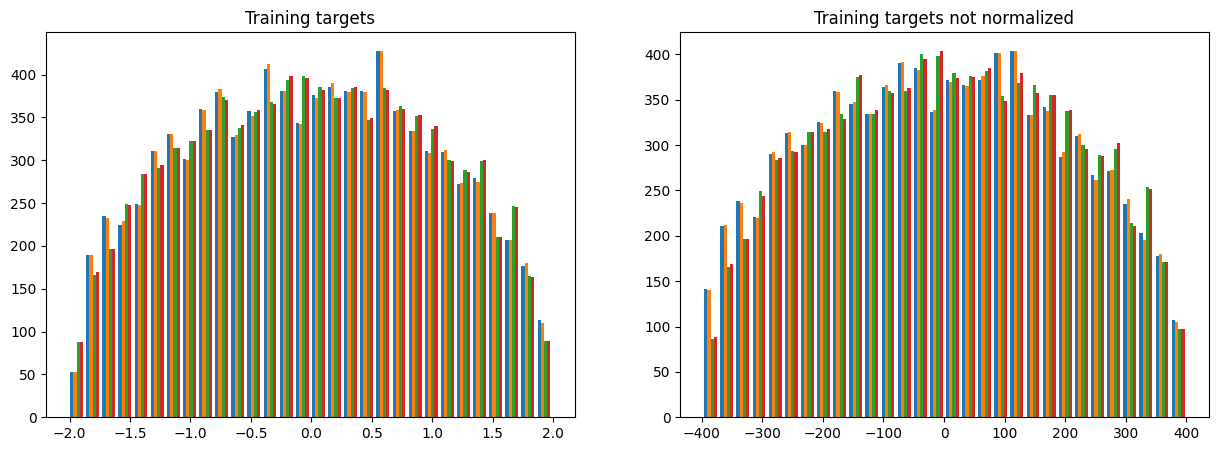

In [5]:
all_targets_tensor_not_norm = torch.stack([graph.y[0] for graph in train_graph_list])

#standardize features and targtets
train_graph_list,inv_targets_train = standardize_graph(train_graph_list)
val_graph_list,inv_targets_val = standardize_graph(val_graph_list)

all_targets_tensor = torch.stack([graph.y[0] for graph in train_graph_list])

fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(all_targets_tensor.numpy(),bins=30)
axs[0].set_title('Training targets')
axs[1].hist(all_targets_tensor_not_norm.numpy(),bins=30)
axs[1].set_title('Training targets not normalized')



In [6]:
##DATASET AND MODEL DEFINITION

#Dataset: serves to fetch graph data on dataloaders or training loop. Its a standard torch class to manage information, transfrom and iterate over it
class Ice_graph_dataset(Dataset):
    def __init__(self, data_list, transform = None):
        super(Ice_graph_dataset, self).__init__()

        # List of graphs
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        if self.transform is not None:
            data.x = self.transform(data.x.unsqueeze(dim=0).moveaxis(-1,0)).squeeze().moveaxis(0,-1)

        return data
    
#Toy GNN model
class GCNN_node(nn.Module):

    def __init__(self, num_features, hidden_channels, output_size):
        super(GCNN_node, self).__init__()
        # conv layers as a test [WIP]
        self.conv1 = ChebConv(num_features, hidden_channels,K=1)
        self.fc = nn.Linear(hidden_channels, output_size)

    def forward(self, x, edge_index,edge_attr):
        x = self.conv1(x, edge_index,edge_attr)
        x = F.relu(x)

        # Global pooling to aggregate node features (... not sure how elegant)
        x = torch.mean(x, dim=0)

        # Fully connected layer for the final output
        x = self.fc(x)


        return x

In [7]:
# TRAINING LOOP

#create datasets and loaders
train_dataset = Ice_graph_dataset(train_graph_list, transform=None)
val_dataset = Ice_graph_dataset(val_graph_list, transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

example_graph = next(iter(train_dataset)) #just to get the num_features

num_features = example_graph.x.shape[-1]  # Node feature dimension
hidden_channels = 12
num_classes = example_graph.y[0].shape[0] # trajectory lenght *2, since we have x,y.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNN_node(num_features, hidden_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.95)
loss = nn.MSELoss()
num_epochs = 60

#trianing loop
training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    training_loss = process_dataloader(model, train_dataloader, device, optimizer, scheduler, loss)
    training_losses.append(training_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {training_loss:.8f}")

    val_loss = process_dataloader(model, val_dataloader, device, criterion=loss)
    validation_losses.append(val_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {val_loss:.8f}")

    scheduler.step() if scheduler else None



Epoch 1/60, Average Training Loss: 0.04181903
Epoch 1/60, Average Validation Loss: 0.00237991
Epoch 6/60, Average Training Loss: 0.00021397
Epoch 6/60, Average Validation Loss: 0.00021606
Epoch 11/60, Average Training Loss: 0.00010408
Epoch 11/60, Average Validation Loss: 0.00008459
Epoch 16/60, Average Training Loss: 0.00005879
Epoch 16/60, Average Validation Loss: 0.00010684
Epoch 21/60, Average Training Loss: 0.00004284
Epoch 21/60, Average Validation Loss: 0.00006663
Epoch 26/60, Average Training Loss: 0.00003318
Epoch 26/60, Average Validation Loss: 0.00007096
Epoch 31/60, Average Training Loss: 0.00002613
Epoch 31/60, Average Validation Loss: 0.00005664
Epoch 36/60, Average Training Loss: 0.00002117
Epoch 36/60, Average Validation Loss: 0.00004249
Epoch 41/60, Average Training Loss: 0.00001732
Epoch 41/60, Average Validation Loss: 0.00003779
Epoch 46/60, Average Training Loss: 0.00001469
Epoch 46/60, Average Validation Loss: 0.00003799
Epoch 51/60, Average Training Loss: 0.000013

In [8]:
#define metrics
mse =  nn.MSELoss(reduction='none')
mae = nn.L1Loss(reduction='none')

lossess = []
targets = []
predictions = []
init_coords = []
for graph in train_dataset:
        graph = graph.to(device)
        output = model(graph.x, graph.edge_index, graph.edge_attr).cpu().detach().numpy()
        target = graph.y[0].cpu().detach().numpy()
        targets.append(target) #target
        predictions.append(output) #predicted
        init_coords.append(graph.y[-1])#initial coords


init_coords = np.stack(init_coords)*1000
targets = torch.tensor(targets)
predictions = torch.tensor(predictions)
#inverse norrmalization
target_inv = inv_targets_train(targets.reshape(-1,2,2).moveaxis(1,0)).moveaxis(0,1).reshape(-1,4)
predicted_inv = inv_targets_train(predictions.reshape(-1,2,2).moveaxis(1,0)).moveaxis(0,1).reshape(-1,4)
#get original coordinates in km
target_coords = torch.stack([target_inv[:,:iterations+1],target_inv[:,iterations+1:]],dim=1)*1000
predicted_coords = torch.stack([predicted_inv[:,:iterations+1],predicted_inv[:,iterations+1:]],dim=1)*1000


#error over position
rmse_position = torch.sqrt(torch.mean(mse(target_coords,predicted_coords),dim=[1]))
#error over velocity
target_vel = velocity_from_coords(np.array(target_coords))
predicted_vel = velocity_from_coords(np.array(predicted_coords))
#speed
target_vel_norm = velocity_norm(target_vel)
predicted_vel_norm =  velocity_norm(predicted_vel)
mae_vel_norm = mae(target_vel_norm,predicted_vel_norm)
#angle
angles = velocity_angle(predicted_vel,target_vel)

/tmp/ipykernel_30010/1102337477.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1699152694053/work/torch/csrc/utils/tensor_new.cpp:261.)
  targets = torch.tensor(targets)


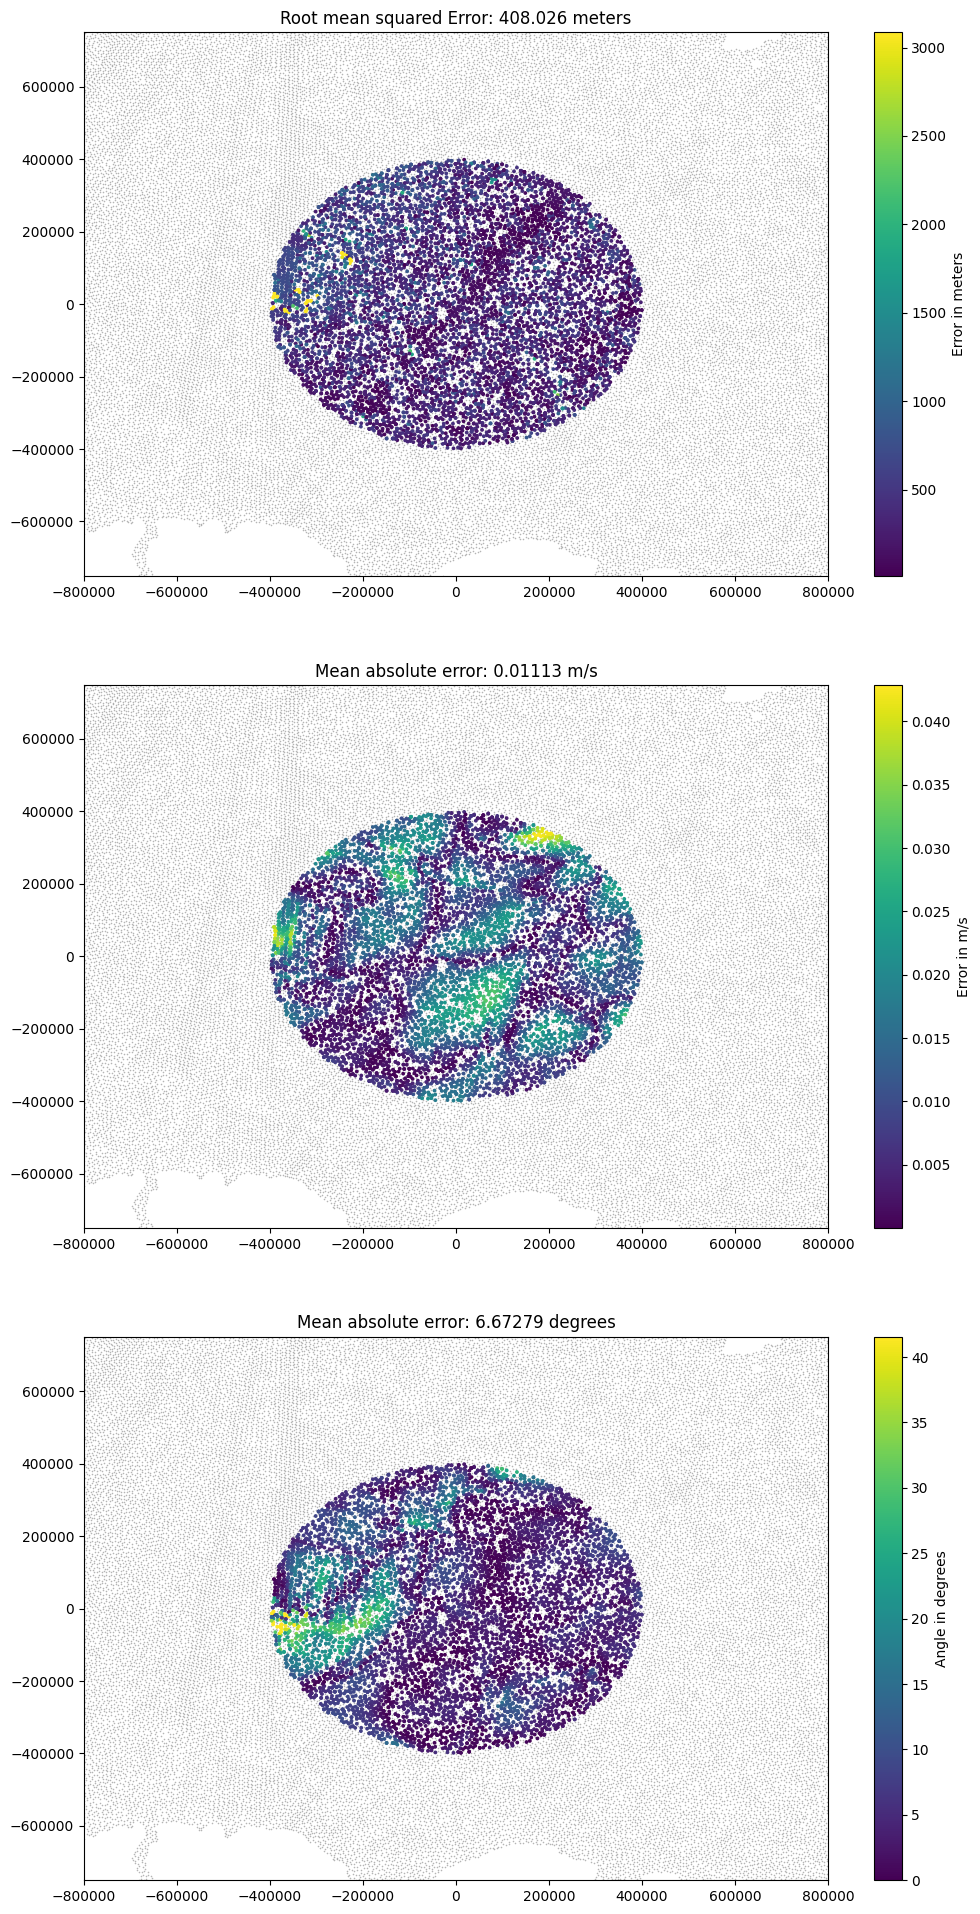

In [9]:

position_spatial_mean = torch.mean(rmse_position,dim=1)
velocity_spatial_mean = torch.mean(mae_vel_norm,dim=0)
angle_spatial_mean = torch.mean(angles, dim=0)

position_absolute_mean = float(torch.mean(rmse_position))
velocity_absolute_mean = float(torch.mean(mae_vel_norm))
angle_absolute_mean = float(torch.mean(angles))

position_std = float(torch.std(rmse_position))
velocity_std = float(torch.std(mae_vel_norm))
angle_std = float(torch.std(angles))


fig, axs = plt.subplots(3,1,figsize=(12,24))

#position
axs[0].scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
im = axs[0].scatter(init_coords[:,0],init_coords[:,1],c=np.clip(position_spatial_mean,0,position_absolute_mean+5*position_std),s=3, cmap='viridis')
axs[0].set_xlim([-0.8e6, 0.8e6])
axs[0].set_ylim([-0.75e6, 0.75e6])
axs[0].set_title("Root mean squared Error: "+str(position_absolute_mean)[:7]+" meters")
plt.colorbar( im, label="Error in meters")

#velocity
im = axs[1].scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
im = axs[1].scatter(init_coords[:,0],init_coords[:,1],c=np.clip(velocity_spatial_mean,0,velocity_absolute_mean+5*velocity_std),s=3, cmap='viridis')
axs[1].set_xlim([-0.8e6, 0.8e6])
axs[1].set_ylim([-0.75e6, 0.75e6])
axs[1].set_title("Mean absolute error: "+str(velocity_absolute_mean)[:7]+" m/s")
plt.colorbar( im, label="Error in m/s")

#angle
im = axs[2].scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
im = axs[2].scatter(init_coords[:,0],init_coords[:,1],c=np.clip(angle_spatial_mean,0,angle_absolute_mean+5*angle_std),s=3, cmap='viridis')
axs[2].set_xlim([-0.8e6, 0.8e6])
axs[2].set_ylim([-0.75e6, 0.75e6])
axs[2].set_title("Mean absolute error: "+str(angle_absolute_mean)[:7]+" degrees")
plt.colorbar( im, label="Angle in degrees")




Text(0.5, 0, 'Angle degrees)')

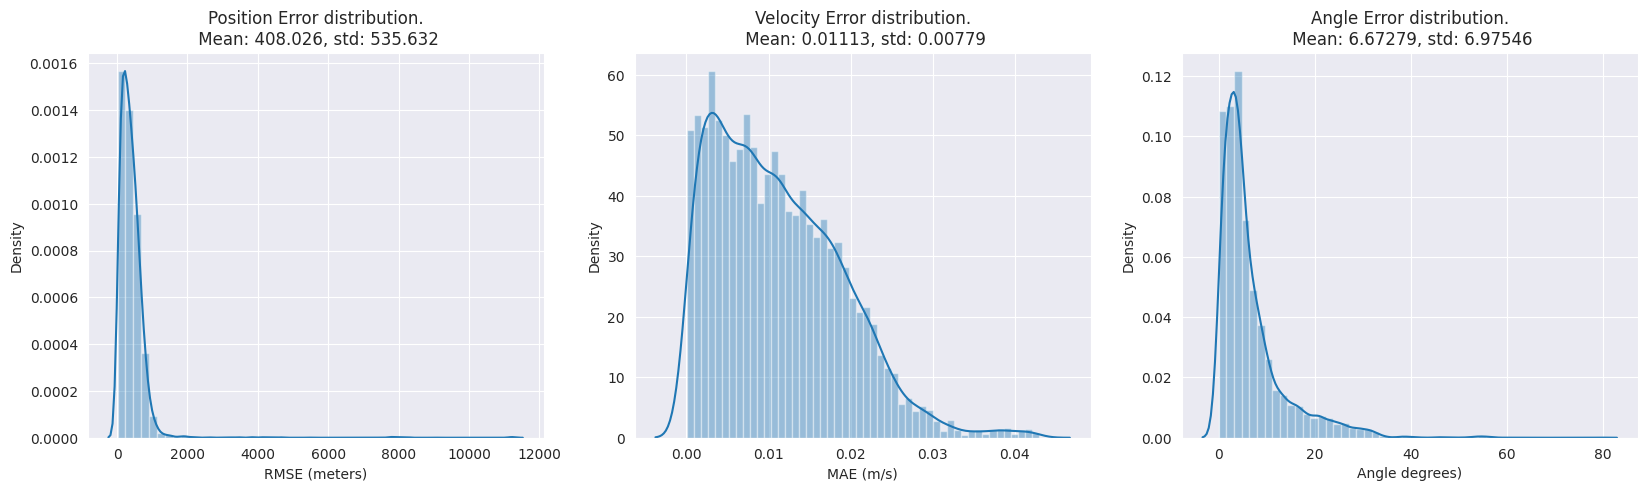

In [11]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#error data distributions
sns.set_style('darkgrid')

fig, axs = plt.subplots(1,3,figsize=(20,5))

sns.distplot(ax=axs[0],a=position_spatial_mean,bins=50)
axs[0].set_title(f"Position Error distribution.\n Mean: {str(position_absolute_mean)[:7]}, std: {str(position_std)[:7]}")
axs[0].set_xlabel("RMSE (meters)")

sns.distplot(ax=axs[1],a=velocity_spatial_mean,bins=50)
axs[1].set_title(f"Velocity Error distribution.\n Mean: {str(velocity_absolute_mean)[:7]}, std: {str(velocity_std)[:7]}")
axs[1].set_xlabel("MAE (m/s)")

sns.distplot(ax=axs[2],a=angle_spatial_mean,bins=50)
axs[2].set_title(f"Angle Error distribution.\n Mean: {str(angle_absolute_mean)[:7]}, std: {str(angle_std)[:7]}")
axs[2].set_xlabel("Angle degrees)")




Text(0.5, 0, 'Lead time (hours)')

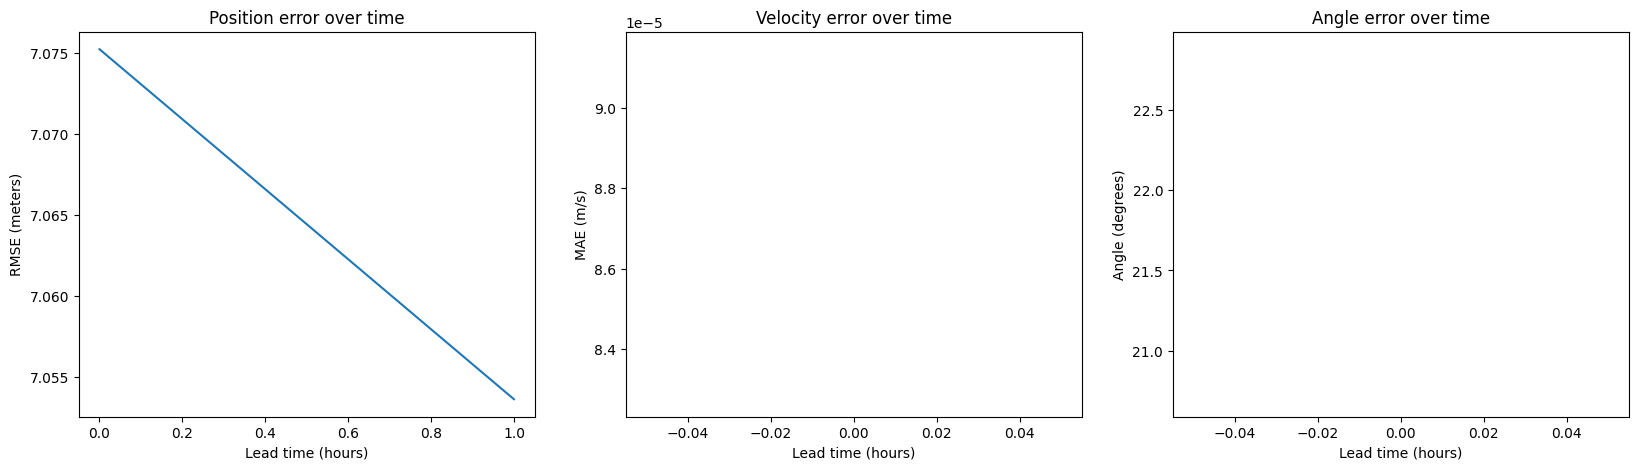

In [10]:
#plot error over time
position_lead_mean = torch.mean(rmse_position,dim=0)
velocity_lead_mean = torch.mean(mae_vel_norm,dim=1)
angle_lead_mean = torch.mean(angles, dim=1)


fig, axs = plt.subplots(1,3,figsize=(20,5))

axs[0].plot(position_lead_mean)
axs[0].set_title("Position error over time")
axs[0].set_ylabel("RMSE (meters)")
axs[0].set_xlabel("Lead time (hours)")

axs[1].plot(velocity_lead_mean)
axs[1].set_title("Velocity error over time")
axs[1].set_ylabel("MAE (m/s)")
axs[1].set_xlabel("Lead time (hours)")

axs[2].plot(angle_lead_mean)
axs[2].set_title("Angle error over time")
axs[2].set_ylabel("Angle (degrees)")
axs[2].set_xlabel("Lead time (hours)")

In [52]:
target_x,target_y

(tensor([-1675.9901, -1675.8889]), tensor([174.2000, 175.3058]))

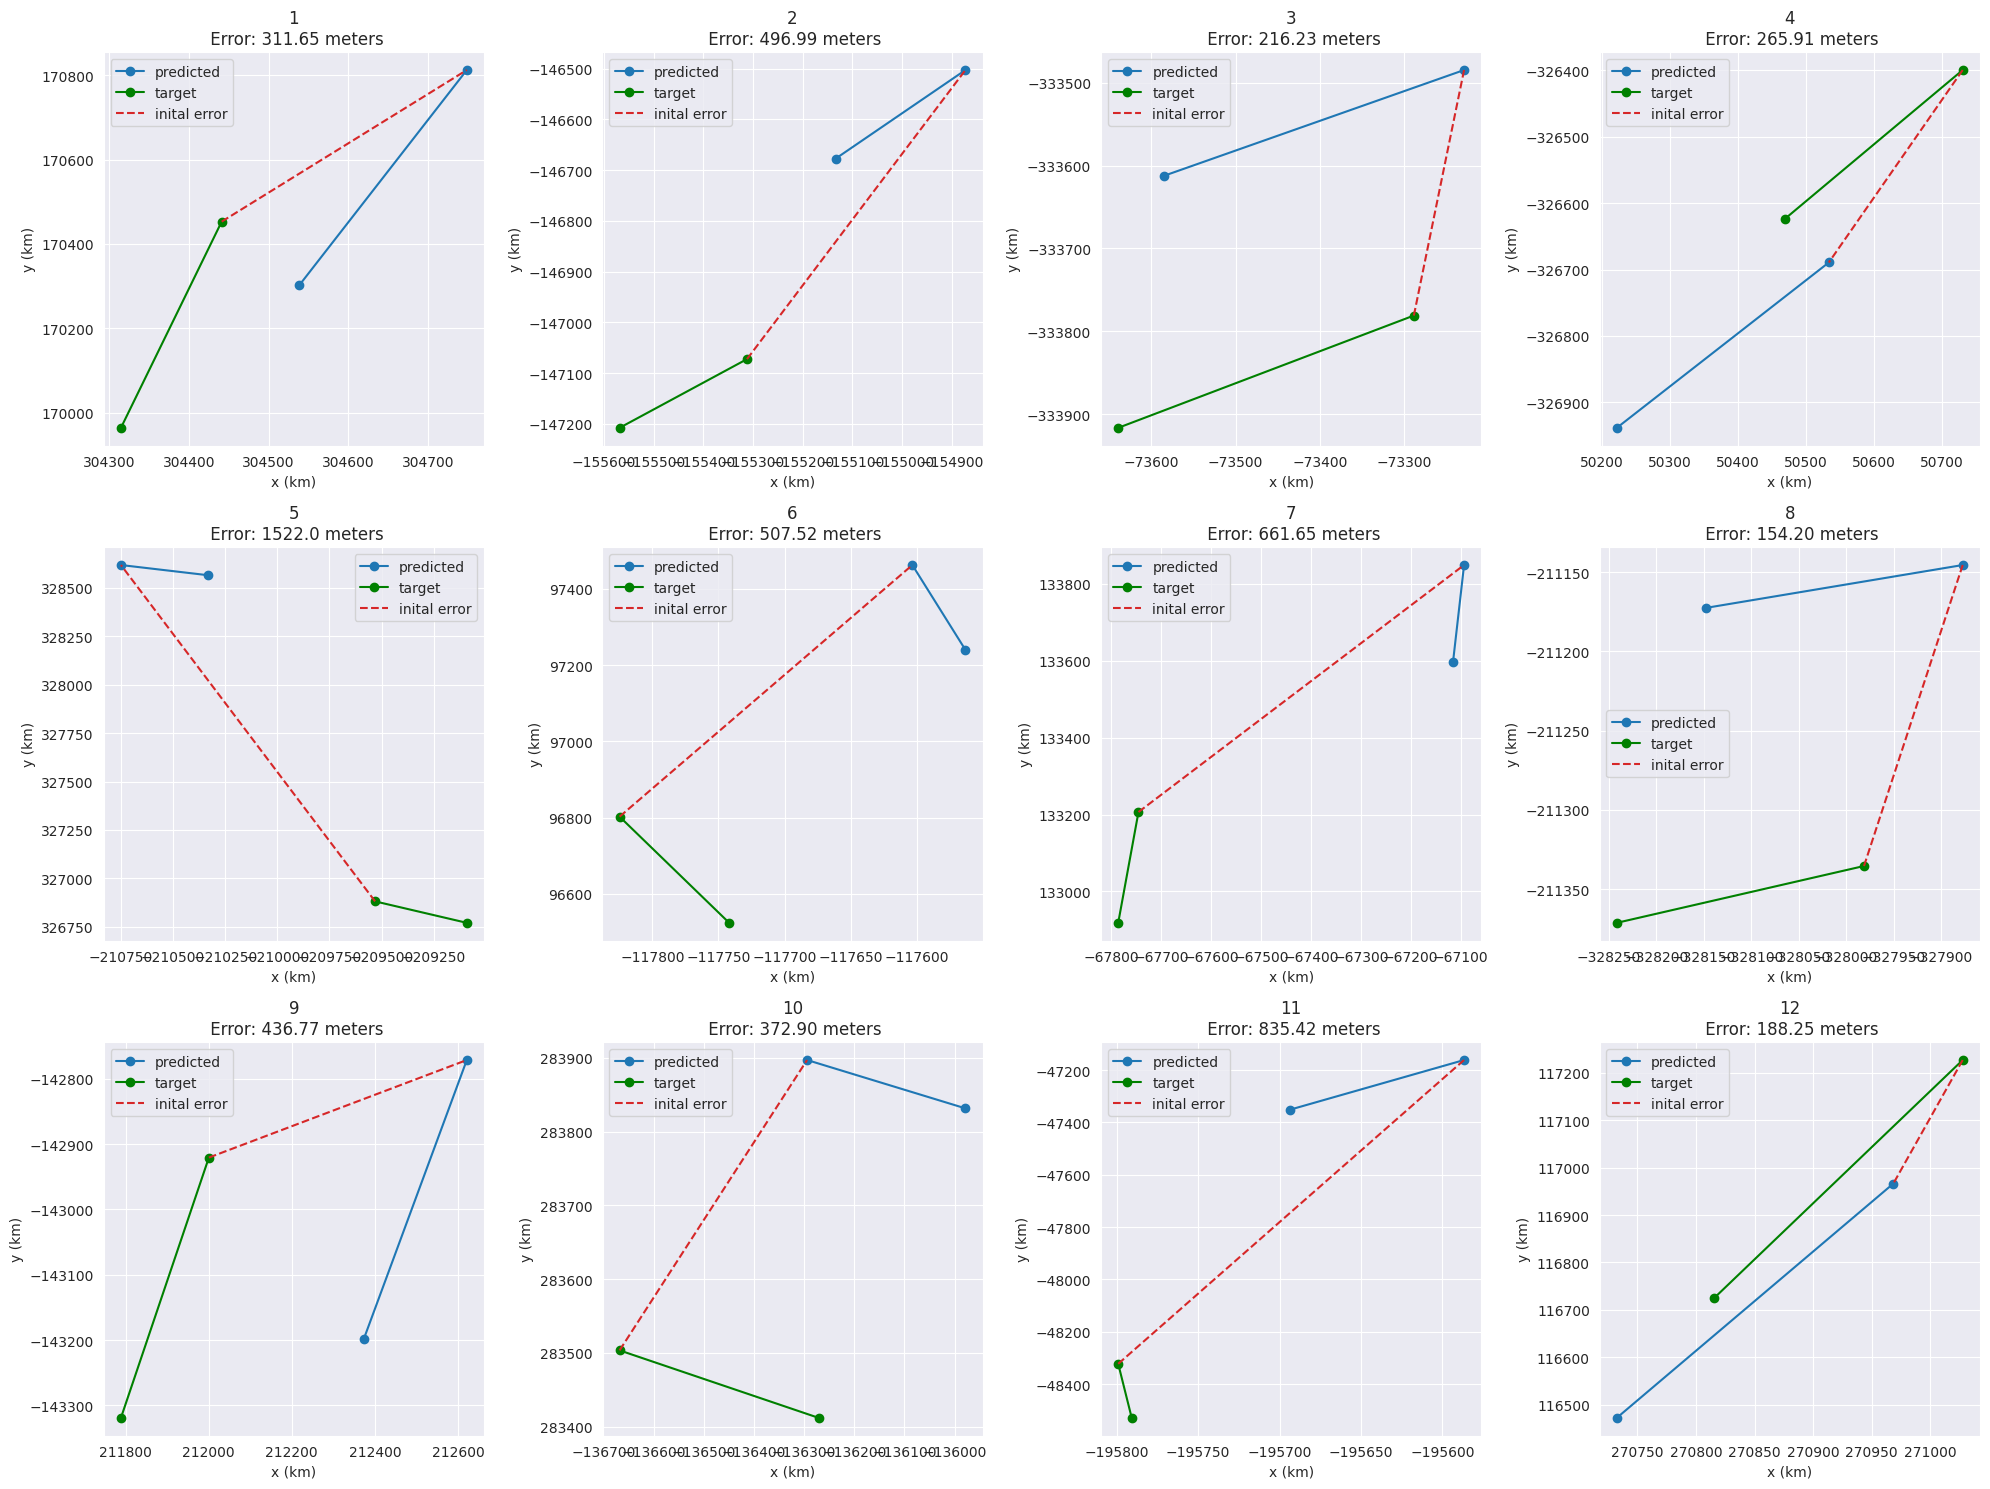

In [12]:
samples = [33, 222, 111,  666,
           333,4,44,555,
           341, 453, 23, 800]

target_iter = iterations+1
fig,axs = plt.subplots(3,4,figsize=(20,15))

for i,element in enumerate(samples):
    target = target_coords[element]
    output = predicted_coords[element]
    target_x,target_y = target
    pred_x,pred_y = output
   
    error = torch.sqrt(torch.mean(mse(torch.tensor(output),torch.tensor(target)))).item()
    
    axs.flatten()[i].plot(pred_x,pred_y, c='tab:blue',label="predicted",marker='o')
    axs.flatten()[i].plot(target_x,target_y, c='green',label="target",marker='o')

    axs.flatten()[i].plot([target_x[0],pred_x[0]],[target_y[0],pred_y[0]], c='tab:red',label="inital error",linestyle="dashed")

    axs.flatten()[i].legend()
    axs.flatten()[i].set_title(f"{i+1}\n Error: "+str(error)[:6]+" meters")
    axs.flatten()[i].set_xlabel("x (km)")
    axs.flatten()[i].set_ylabel("y (km)")
plt.tight_layout()
